Checking frequency stability for jumprope (Accelerometer): False
Checking frequency stability for jumprope (Gyroscope): False
Checking frequency stability for run (Accelerometer): False
Checking frequency stability for run (Gyroscope): False
Checking frequency stability for walk (Accelerometer): False
Checking frequency stability for walk (Gyroscope): False
Anomalies in jumprope (Accelerometer): 10092
Anomalies in jumprope (Gyroscope): 23320
Anomalies in run (Accelerometer): 18642
Anomalies in run (Gyroscope): 3715
Anomalies in walk (Accelerometer): 17855
Anomalies in walk (Gyroscope): 9216


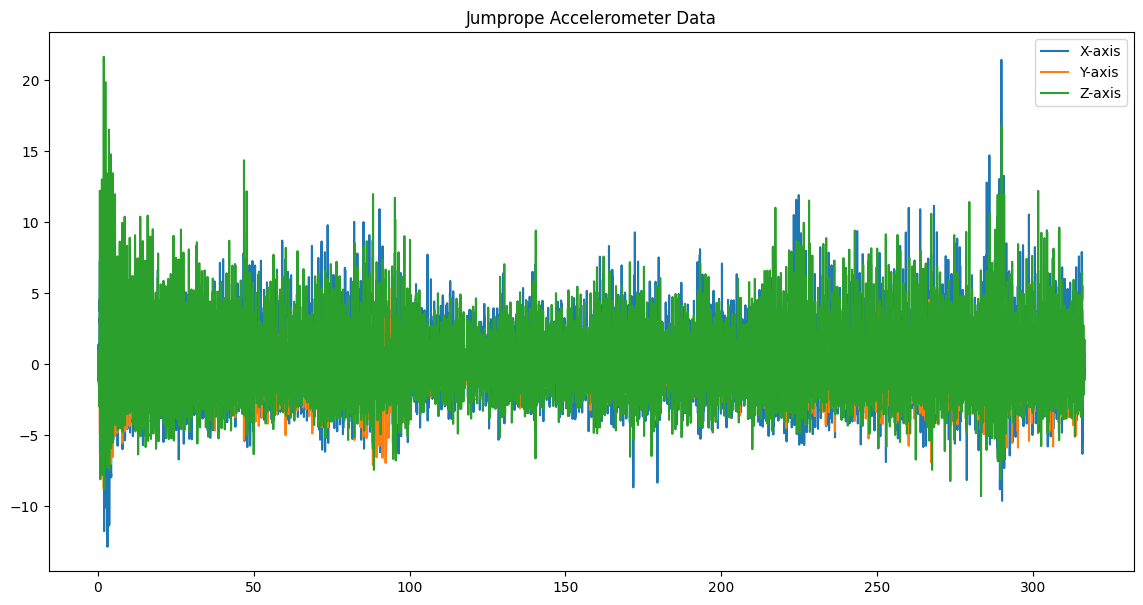

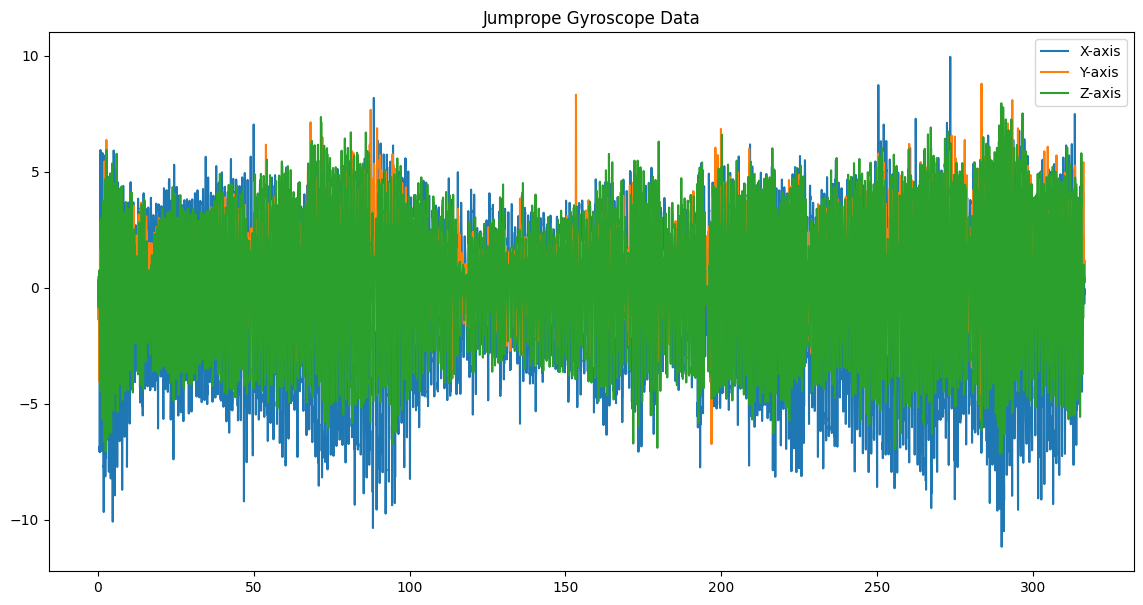

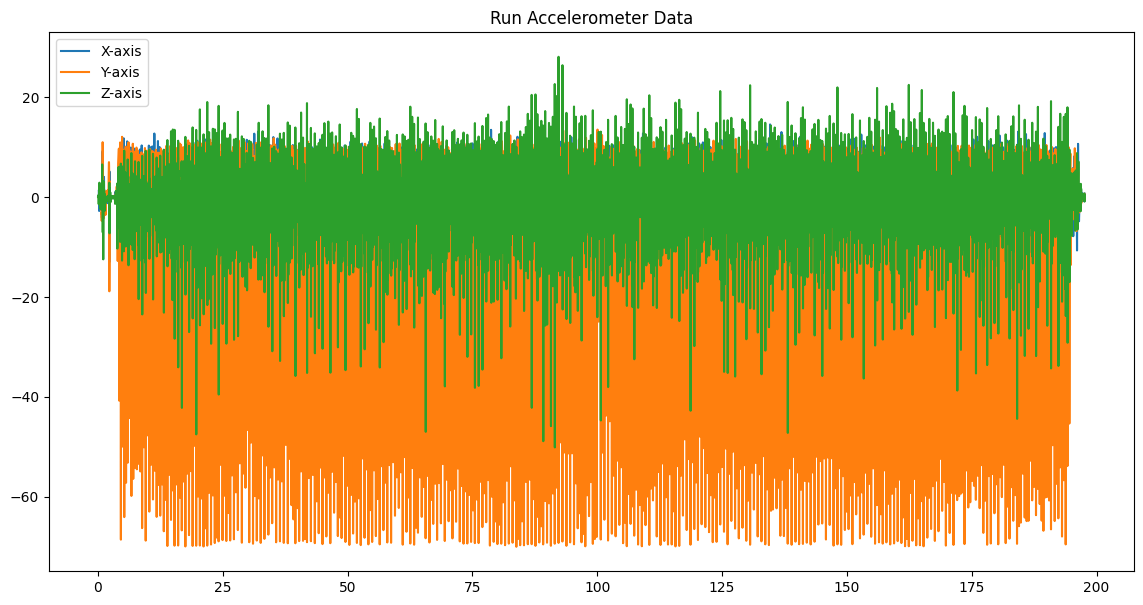

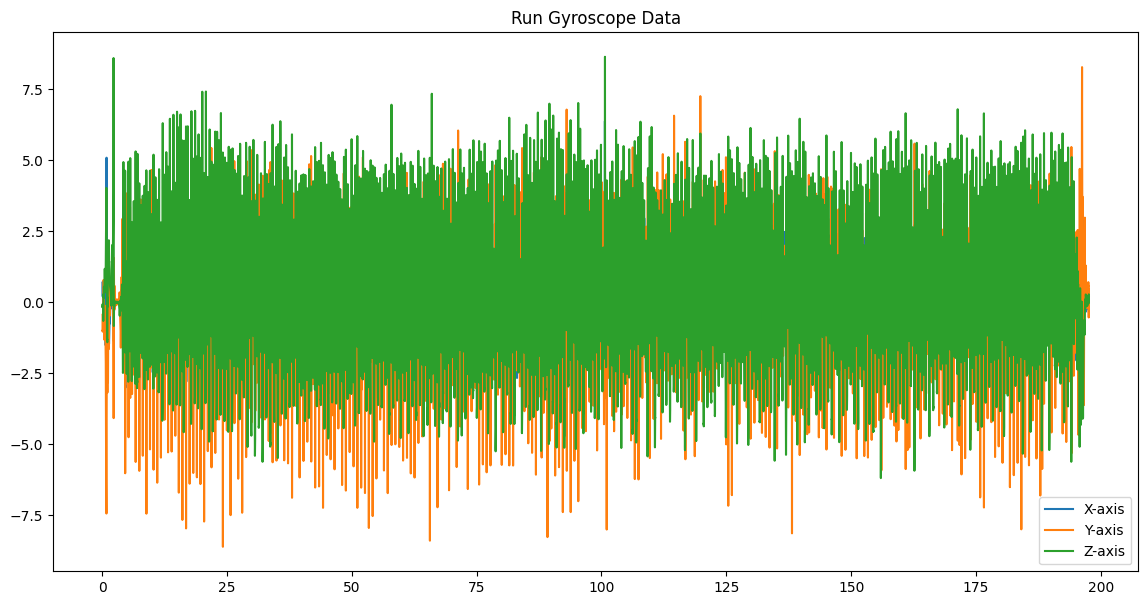

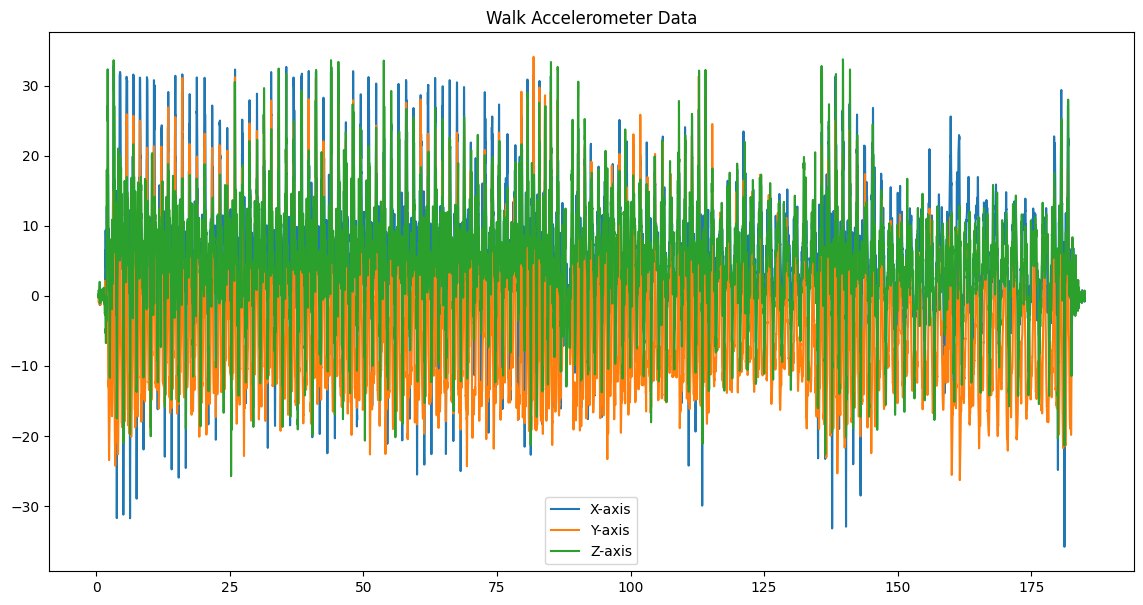

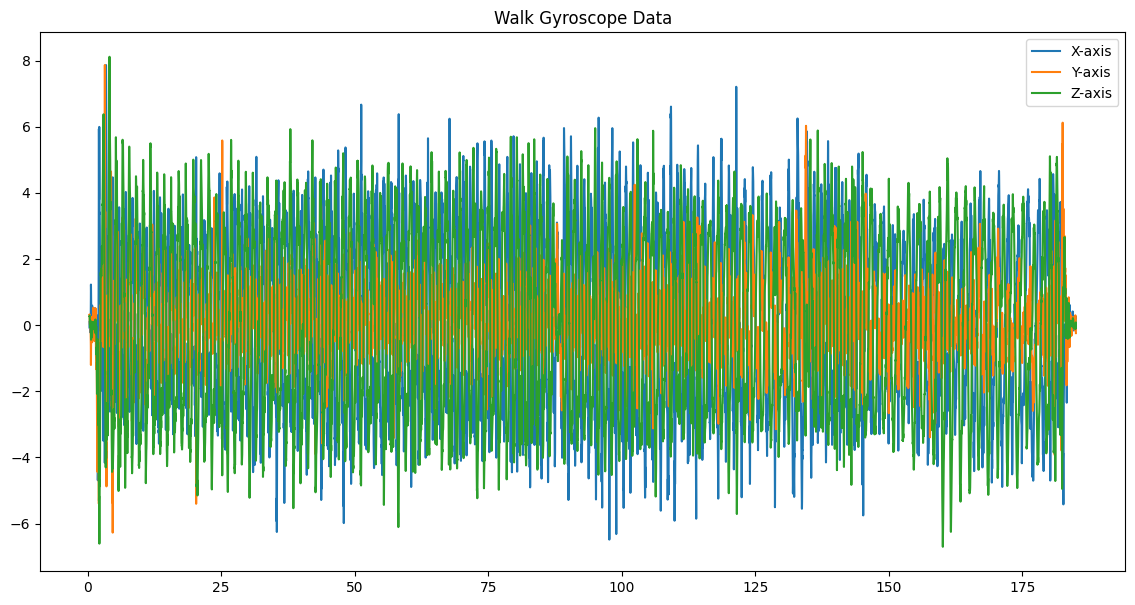

Accuracy: 0.9392655367231638


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Функція для завантаження даних
def load_data(file_path):
    return pd.read_csv(file_path)

# Завантаження даних акселерометра та гіроскопа
activities = ['jumprope', 'run', 'walk']
data_acc = {activity: load_data(f'{activity}_accelerometer.csv') for activity in activities}
data_gyro = {activity: load_data(f'{activity}_gyroscope.csv') for activity in activities}

# Функція для перевірки стабільності частоти
def check_frequency_stability(data, frequency=30):
    data['time_diff'] = data['seconds_elapsed'].diff()
    stable = np.allclose(data['time_diff'].dropna().values, 1/frequency, atol=1e-2)
    return stable

# Перевірка стабільності частоти
for activity in activities:
    print(f'Checking frequency stability for {activity} (Accelerometer):', check_frequency_stability(data_acc[activity]))
    print(f'Checking frequency stability for {activity} (Gyroscope):', check_frequency_stability(data_gyro[activity]))

# Функція для виявлення аномалій
def detect_anomalies(data, threshold=3):
    anomalies = data[(np.abs(data['x']) > threshold) | 
                     (np.abs(data['y']) > threshold) | 
                     (np.abs(data['z']) > threshold)]
    return anomalies

# Виявлення аномалій
for activity in activities:
    anomalies_acc = detect_anomalies(data_acc[activity])
    anomalies_gyro = detect_anomalies(data_gyro[activity])
    print(f'Anomalies in {activity} (Accelerometer):', len(anomalies_acc))
    print(f'Anomalies in {activity} (Gyroscope):', len(anomalies_gyro))

# Функція для візуалізації даних
def plot_data(data, title):
    plt.figure(figsize=(14, 7))
    plt.plot(data['seconds_elapsed'], data['x'], label='X-axis')
    plt.plot(data['seconds_elapsed'], data['y'], label='Y-axis')
    plt.plot(data['seconds_elapsed'], data['z'], label='Z-axis')
    plt.legend()
    plt.title(title)
    plt.show()

# Візуалізація даних
for activity in activities:
    plot_data(data_acc[activity], f'{activity.capitalize()} Accelerometer Data')
    plot_data(data_gyro[activity], f'{activity.capitalize()} Gyroscope Data')

# Функція для поділу на вікна
def split_into_windows(data, window_size=2, frequency=30):
    window_length = window_size * frequency
    windows = [data.iloc[i:i+window_length] for i in range(0, len(data), window_length)]
    return windows

# Функція для обчислення статистичних параметрів
def compute_statistics(windows):
    stats = []
    for window in windows:
        if len(window) == 0:
            continue
        stats.append({
            'mean_x': window['x'].mean(),
            'std_x': window['x'].std(),
            'min_x': window['x'].min(),
            'max_x': window['x'].max(),
            'range_x': window['x'].max() - window['x'].min(),
            'mean_y': window['y'].mean(),
            'std_y': window['y'].std(),
            'min_y': window['y'].min(),
            'max_y': window['y'].max(),
            'range_y': window['y'].max() - window['y'].min(),
            'mean_z': window['z'].mean(),
            'std_z': window['z'].std(),
            'min_z': window['z'].min(),
            'max_z': window['z'].max(),
            'range_z': window['z'].max() - window['z'].min(),
        })
    return pd.DataFrame(stats)

# Обчислення статистичних параметрів для кожної активності
stats_acc = {activity: compute_statistics(split_into_windows(data_acc[activity])) for activity in activities}
stats_gyro = {activity: compute_statistics(split_into_windows(data_gyro[activity])) for activity in activities}

# Об'єднання статистичних даних в один DataFrame
all_stats = []
for activity in activities:
    stats_acc[activity]['activity'] = activity
    stats_gyro[activity]['activity'] = activity
    stats_acc[activity]['sensor'] = 'accelerometer'
    stats_gyro[activity]['sensor'] = 'gyroscope'
    all_stats.append(stats_acc[activity])
    all_stats.append(stats_gyro[activity])

df_stats = pd.concat(all_stats, ignore_index=True)


# Підготовка даних для класифікації
X = df_stats.drop(columns=['activity', 'sensor'])
y = df_stats['activity']

# Розподіл на тренувальну та тестову вибірки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Тренування моделі класифікації
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Оцінка точності моделі
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
